# MOVEの結果を使ってクラスタリング

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

In [7]:
latent = pd.read_csv("results/latent_space/latent_space.tsv", sep="\t", index_col=0)
adata_latent = sc.AnnData(latent, obs=pd.DataFrame(index=latent.index))
adata_latent

AnnData object with n_obs × n_vars = 444 × 2

In [8]:
sc.pp.neighbors(adata_latent, n_neighbors=10, use_rep="X") # 150次元を10次元にする
sc.tl.tsne(adata_latent, use_rep="X", random_state=42) 
sc.tl.leiden(adata_latent, resolution=1.0, key_added="latent_leiden")

In [4]:
rna  = pd.read_csv("data/rna_z_comsam_row.tsv", sep="\t", index_col=0)
meth = pd.read_csv("data/meth_z_comsam_row.tsv", sep="\t", index_col=0)
cnv  = pd.read_csv("data/cnv_z_comsam_row.tsv", sep="\t", index_col=0)

In [12]:
# 共通化して、連結
common = rna.index.intersection(meth.index).intersection(cnv.index)
multi = pd.concat([rna.loc[common], meth.loc[common], cnv.loc[common]], axis=1)
adata_pca = sc.AnnData(multi, obs=pd.DataFrame(index=common))
adata_pca

/home/omen/miniconda3/envs/env_py312/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 444 × 135679

In [13]:
# デフォルトVAEと同じ150次元に落とす
sc.pp.pca(adata_pca, n_comps=150, svd_solver="arpack")
adata_pca.obsm["X_pca150"] = adata_pca.obsm["X_pca"] 

In [15]:
# 近傍→t-SNE→leiden
sc.pp.neighbors(adata_pca, n_neighbors=10, use_rep="X_pca150")
sc.tl.tsne(adata_pca, use_rep="X_pca150", random_state=42)
sc.tl.leiden(adata_pca, resolution=1.0, key_added="pca150_leiden")

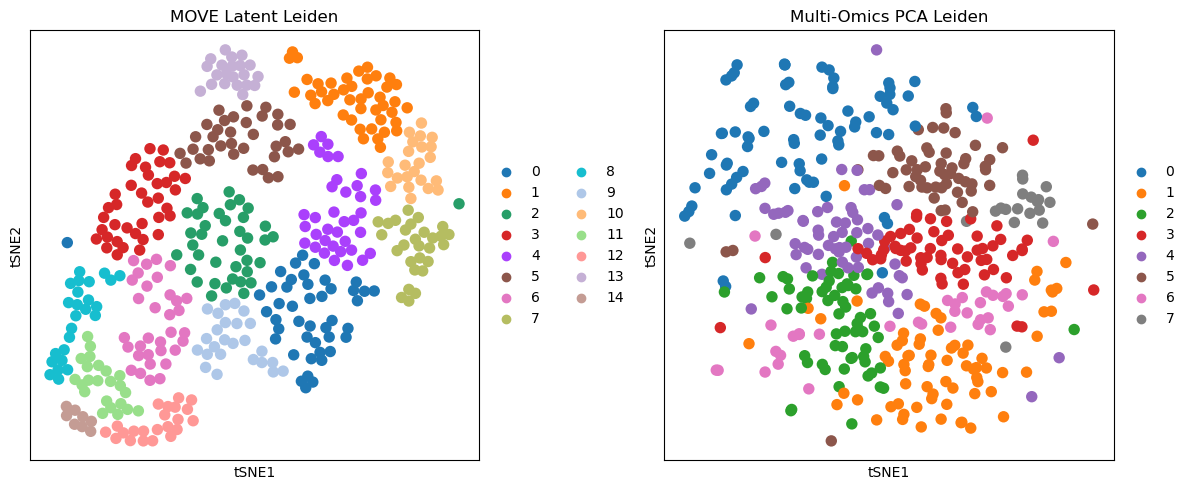

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sc.pl.tsne(
    adata_latent,
    color="latent_leiden",
    ax=axes[0],
    title="MOVE Latent Leiden",
    show=False
)
sc.pl.tsne(
    adata_pca,
    color="pca150_leiden",
    ax=axes[1],
    title="Multi-Omics PCA Leiden",
    show=False
)

plt.tight_layout()
plt.show()

In [18]:
labels_vae = adata_latent.obs["latent_leiden"].astype(int)
labels_pca = adata_pca.obs["pca150_leiden"].astype(int)

In [20]:
adata_latent.obsm["X_tsne"]

array([[ 9.81546879e-01,  2.18612022e+01],
       [ 1.96950150e+01,  8.07989311e+00],
       [-2.38077602e+01, -2.43732738e+01],
       [-4.55932093e+00, -1.38005762e+01],
       [-5.39611864e+00,  1.30985556e+01],
       [ 2.40998135e+01, -3.44960785e+00],
       [ 1.23591232e+01,  1.85082591e+00],
       [-5.40066361e-01,  1.32846022e+01],
       [-1.64584923e+01, -1.38338470e+01],
       [ 1.68910141e+01, -1.06198406e+00],
       [-1.93622577e+00,  1.75746117e+01],
       [-1.81129951e+01, -2.63045826e+01],
       [ 4.18386269e+00,  9.40649986e+00],
       [-2.27714729e+01, -2.46958942e+01],
       [ 7.35925317e-01,  1.03179398e+01],
       [-1.59676037e+01,  1.09359865e+01],
       [-9.48894787e+00, -2.07739410e+01],
       [ 9.19258785e+00, -2.45882607e+00],
       [-2.53309298e+00,  7.33862257e+00],
       [ 7.74745798e+00, -4.00077057e+00],
       [-5.52088547e+00, -8.63860321e+00],
       [-6.30935001e+00,  1.55412579e+00],
       [ 8.29198435e-02,  5.11967230e+00],
       [ 6.

In [21]:
adata_pca.obsm

AxisArrays with keys: X_pca, X_pca150, X_tsne

In [23]:
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score
# --- 1) ARI: VAE vs PCA の一致度 ---
ari = adjusted_rand_score(labels_vae, labels_pca)
print(f"Adjusted Rand Index (VAE vs PCA): {ari:.3f}")

# --- 2) Silhouette Score: 各手法のクラスタの凝集度/分離度 ---
sil_vae = silhouette_score(adata_latent.obsm["X_tsne"], labels_vae)
sil_pca = silhouette_score(adata_pca.obsm["X_tsne"], labels_pca)
print(f"Silhouette Score (VAE): {sil_vae:.3f}")
print(f"Silhouette Score (PCA): {sil_pca:.3f}")

# --- 3) Calinski‐Harabasz Index（任意） ---
ch_vae = calinski_harabasz_score(adata_latent.obsm["X_tsne"], labels_vae)
ch_pca = calinski_harabasz_score(adata_pca.obsm["X_tsne"], labels_pca)
print(f"Calinski-Harabasz (VAE): {ch_vae:.1f}")
print(f"Calinski-Harabasz (PCA): {ch_pca:.1f}")

Adjusted Rand Index (VAE vs PCA): 0.250
Silhouette Score (VAE): 0.331
Silhouette Score (PCA): 0.147
Calinski-Harabasz (VAE): 393.5
Calinski-Harabasz (PCA): 107.0


## クラスターを取り出す

In [24]:
sample_clusters = pd.Series(adata_latent.obs["latent_leiden"], name="cluster")  # クラスター
sample_clusters

sample
TCGA-05-4384    13
TCGA-05-4390    10
TCGA-05-4396    14
TCGA-05-4405     9
TCGA-05-4410     5
                ..
TCGA-NJ-A55O    12
TCGA-NJ-A55R     1
TCGA-NJ-A7XG     3
TCGA-O1-A52J     7
TCGA-S2-AA1A     2
Name: cluster, Length: 444, dtype: category
Categories (15, object): ['0', '1', '2', '3', ..., '11', '12', '13', '14']

In [25]:
def extract_clusters(adata, key):
    """
    adata.obs[key] に入っているクラスタ番号から
      - sample_clusters : Series( index = sample ID, value = cluster ID )
      - clusters        : list[ list[sample ID] ]  (クラスタごとのサンプル集合)
    を作って返す。
    """
    sample_clusters = adata.obs[key].astype(int).copy()   # 例: "TCGA-xx-xxxx" → 0,1,…
    clusters = [
        sample_clusters.index[sample_clusters == k].tolist()
        for k in sorted(sample_clusters.unique())
    ]
    return sample_clusters, clusters

In [26]:
sample_clusters, clusters = extract_clusters(adata_latent, key="latent_leiden")

In [27]:
clusters

[['TCGA-35-5375',
  'TCGA-38-6178',
  'TCGA-44-3917',
  'TCGA-44-3918',
  'TCGA-44-4112',
  'TCGA-44-6147',
  'TCGA-44-8117',
  'TCGA-49-AARR',
  'TCGA-50-6590',
  'TCGA-50-6593',
  'TCGA-50-6594',
  'TCGA-53-7624',
  'TCGA-55-7281',
  'TCGA-55-7728',
  'TCGA-55-7995',
  'TCGA-55-A48Z',
  'TCGA-55-A491',
  'TCGA-55-A57B',
  'TCGA-62-8394',
  'TCGA-64-5781',
  'TCGA-69-7760',
  'TCGA-69-7980',
  'TCGA-69-8253',
  'TCGA-69-A59K',
  'TCGA-78-7145',
  'TCGA-78-7146',
  'TCGA-78-7147',
  'TCGA-78-7154',
  'TCGA-78-7535',
  'TCGA-86-7954',
  'TCGA-86-8280',
  'TCGA-91-6836',
  'TCGA-91-6847',
  'TCGA-93-7348',
  'TCGA-95-7948',
  'TCGA-95-A4VN',
  'TCGA-97-7546',
  'TCGA-97-7547',
  'TCGA-97-7941',
  'TCGA-99-8025',
  'TCGA-J2-A4AG',
  'TCGA-MP-A4TF',
  'TCGA-MP-A4TK',
  'TCGA-NJ-A55A'],
 ['TCGA-44-2656',
  'TCGA-44-2665',
  'TCGA-44-6146',
  'TCGA-44-7661',
  'TCGA-44-7670',
  'TCGA-49-6742',
  'TCGA-50-5066',
  'TCGA-50-5072',
  'TCGA-53-7626',
  'TCGA-55-6970',
  'TCGA-55-7284',
  'TCGA-5

In [28]:
import joblib
joblib.dump((sample_clusters, clusters), "clusters_latent.pkl")

['clusters_latent.pkl']